In [1]:
import numpy as np
from scipy.stats import sem

# import my functions
# import info_theory_functions as info
from lnl_model_functions import *
from atick_redlich_functions import *
from get_davids_data import *
from image_processing_functions import *

# from scipy.optimize import minimize
# from scipy import fft, arange
# from random import randint
# from cmath import polar
# from numpy.fft import fft2
# from numpy.fft import fftshift
# from sklearn.decomposition import PCA
# from scipy.interpolate import interp1d
from scipy.optimize import curve_fit, minimize
from scipy.stats import sem
from scipy.interpolate import interp1d


# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
from matplotlib.pyplot import *

# note that nonposx(y) for log plots will no longer work with this package
# I recommend against enabling the whole notebook, since some plots come out funny.
# Instead, just use mpld3.display() at the end of cells you want to interact with.
import mpld3
#mpld3.enable_notebook()

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# Import natural images

In [2]:
# choose an image path from cd13A (flood plain, water, horizon) or cd01A (baboons, trees, bushes)
im_path     = '/Users/lmcintosh/data/images/Tkacik/cd13A' # flood plain, water, horizon
num_images  = 100
patch_size  = None
pixelsToDeg = 92./2 # or 2./92 degrees per pixel (spacing)
spacing     = 1./pixelsToDeg # number of degree spacing between pixels
normalize   = 'divisive'
contrast    = 0.35
patches     = load_images(im_path, num_images, patch_size, square=True, 
                          normalize=normalize, effective_contrast=contrast)

Only 78 files in directory.


In [3]:
allRot  = [spectrum2d(p,spacing=spacing,frequencyFlag=False) for p in patches]
specRot = np.mean(allRot, axis=0) # average out the amplitude spectrum over all images
frqRot, tmp = spectrum2d(patches[0],spacing=spacing,frequencyFlag=True)
error = [sem([allRot[j][i] for j in range(len(patches))]) for i in range(len(frqRot))]
originalSpectra = specRot
originalErrors  = error
originalFreqs   = frqRot

# Signal

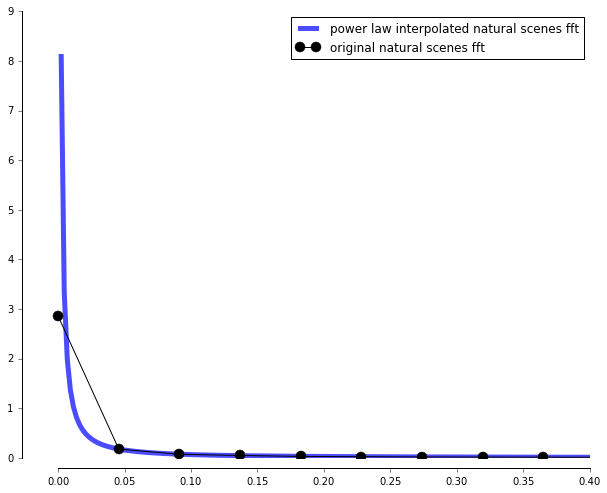

In [4]:
# interpolate signal amplitude
# power law
npoints = 10000
def func(x, a, b):
    return a/(x**b) # adding a constant tends to make moreSpectra have negative numbers
popt, pcov  = curve_fit(func, originalFreqs[1:], originalSpectra[1:])
more_signal_freq   = np.linspace(0., originalFreqs[-1], npoints)[1:]
more_signal_amp = func(more_signal_freq, *popt)

plt.plot(more_signal_freq, more_signal_amp, 'b', linewidth=5, alpha=0.7, label='power law interpolated natural scenes fft')
plt.plot(originalFreqs, originalSpectra, 'k.-', markersize=20, label='original natural scenes fft')
plt.legend()
plt.xlim([-0.02,0.4])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Define information at a given frequency

In [5]:
def info_at_freq(freqs, signal_amplitude, filter_interpolation_function, function_const=1., input_noise=0.12, output_noise=0.35):
    numerator = (signal_amplitude * function_const * filter_interpolation_function(freqs))**2
    denominator = ((input_noise * function_const * filter_interpolation_function(freqs))**2 + output_noise**2)
    return 0.5*np.log2(1.0 + (numerator/denominator))

# Get center width from ganglion cell data

In [6]:
ganglion_rfs = load_ganglion_cells()
interp_ganglions     = get_interp(ganglion_rfs, nPoints = 500, mode='valid')
aligned_ganglion_rfs = np.vstack([y for x,y in interp_ganglions])
valid_space          = interp_ganglions[0][0] - 0.25
mean_ganglion = np.mean(aligned_ganglion_rfs, axis=0)

In [7]:
def diff_of_gaussians(space, center_width, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=center_width, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [8]:
def diff_of_gaussians_fixed_center(space, surround_width, center_strength, surround_strength):
    center = gaussian(x=space, sigma=1.751050, mu=0)
    surround = gaussian(x=space, sigma=surround_width, mu=0)
    difference = center_strength * center - surround_strength * surround
    return difference

In [9]:
popt, pcov = curve_fit(diff_of_gaussians, valid_space, mean_ganglion, p0=[1.7, 7.4, -11, -60])
popt

array([  1.47729653,   8.46181925,  -6.11208239, -25.92723796])

In [10]:
difference = diff_of_gaussians(valid_space, *popt)

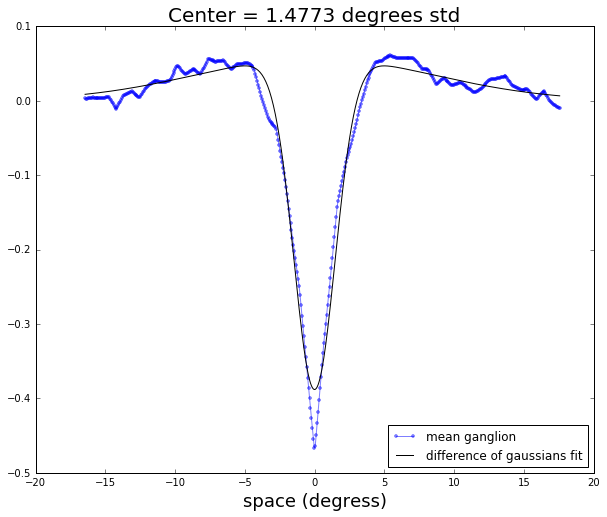

In [11]:
plot(valid_space, mean_ganglion, 'b.-', alpha=0.5, label='mean ganglion')
plot(valid_space, difference, 'k', label='difference of gaussians fit')
plt.legend(loc='lower right')
plt.xlabel('space (degress)', fontsize=18)
plt.title('Center = %0.4f degrees std' %(popt[0]), fontsize=20)

# Define model

In [12]:
def filter_model(horz_weight, ama_weight, center_weight, surround_weight, center_width=1.751050):
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround

    # Amplitude Spectrum of RF
    rf_f_two_sided = abs(np.fft.fft(rf)) / np.prod(rf.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:int((n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:int(((n-1)/2) + 1)]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    rf_interp = interp1d(rf_freqs_one_sided, rf_f_one_sided, kind='slinear', fill_value=[0.0], bounds_error=False)
    
    return rf_interp

## Find ideal filter that maximizes information

In [13]:
input_noise = 0.12
output_noise = 0.35

The relative error from this choice of Lagrangian multiplier is 1.90062207072e-07.


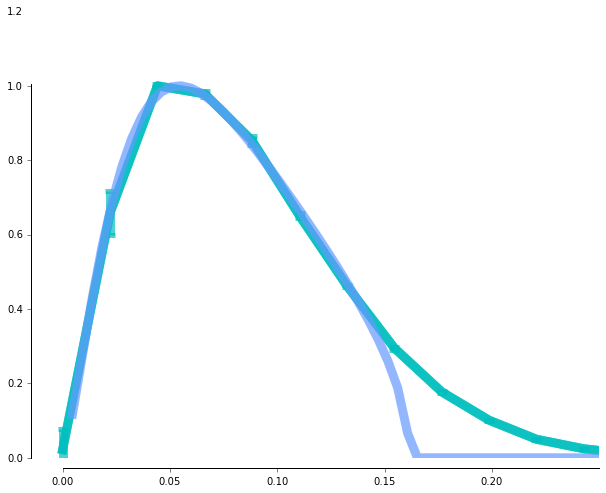

In [14]:
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=input_noise, outputNoise=output_noise,
                                                                     center_weighting=7.7844, surround_weighting=.5085,
                                                                     horz_weighting=.223, ama_weighting=1.165,
                                                                     center_width=1.86945,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=5000, plotFlag='aggregate',
                                                                                       statistics=True)

#### And make an interpolation of it

In [15]:
ideal_filter_interp = interp1d(freq_ideal, filt_ideal/np.nanmax(filt_ideal), kind='linear', 
                               bounds_error=False, fill_value='extrapolate')
output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(output_variance)

1227.34527259


(0, 0.3)

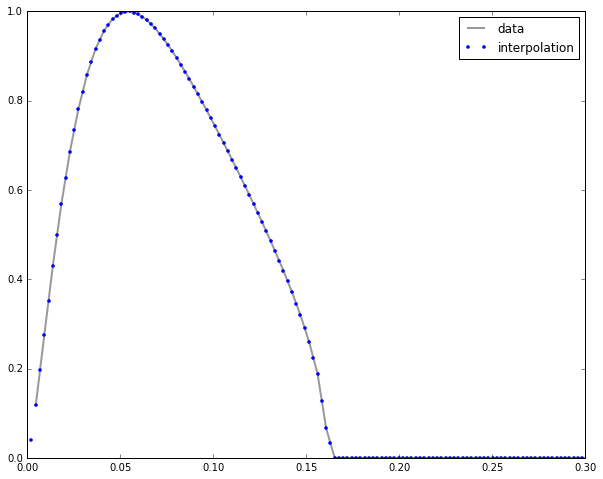

In [16]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), 'k', linewidth=2, alpha=0.4, label='data')
plt.plot(more_signal_freq, ideal_filter_interp(more_signal_freq), 'b.', label='interpolation')
plt.legend()
plt.xlim([0,0.3])

# Now fit the models (full, horizontal only, amacrine only) to ideal filter

In [17]:
popt[0]

1.4772965311658066

In [18]:
cutoff = 0.4
center_width = popt[0]

### Full model

In [19]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
model_freqs, model_fft, horz_weight, ama_weight, center_weight, surround_weight, center_width = fit_ideal(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs),
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
model_interp, model_popt = fit_ideal(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(model_popt)
print('Horizontal weight is %f, Amacrine weight is %f' %(horz_weight, ama_weight))
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 1.70449073 -0.68188641  3.72378361  0.22292512]
Horizontal weight is 2.197360, Amacrine weight is -0.706016
Center weight is 9.735469, Surround weight is 0.447793
Center is 1.477297 std wide


(0, 0.4)

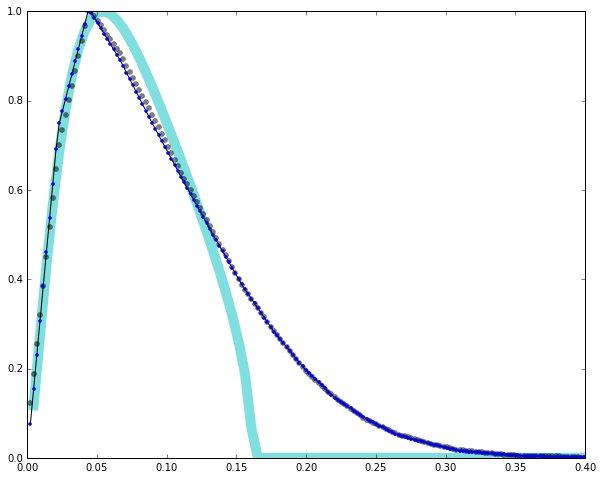

In [20]:
model_filter_interp = filter_model(*model_popt, center_width=center_width)
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='c', linewidth=10, alpha=0.5)
plt.plot(model_freqs, model_fft, 'k.', linewidth=2, markersize=10, alpha=0.5)
plt.plot(lowerer_freqs, model_filter_interp(lowerer_freqs)/np.nanmax(model_filter_interp(lowerer_freqs)), 'k')
plt.plot(model_freqs, model_interp(model_freqs, *model_popt), 'b.')
plt.xlim([0,.4])

### Horizontal model

In [21]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
h_freqs, h_fft, center_weight, surround_weight, center_width = fit_ideal_horz_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
h_interp, h_popt = fit_ideal_horz_only(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(h_popt)
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 0.39680772  0.02962082]
Center weight is 25.864291, Surround weight is 1.930762
Center is 1.477297 std wide


In [22]:
lowerer_freqs = [f for f in more_signal_freq if f < cutoff]
a_freqs, a_fft, center_weight, surround_weight, center_width = fit_ideal_ama_only(lowerer_freqs, 
                                                                                                    ideal_filter_interp(lowerer_freqs), 
                                                                                                    center_width=center_width,
                                                                                                    returnFlag='all')
a_interp, a_popt = fit_ideal_ama_only(lowerer_freqs, ideal_filter_interp(lowerer_freqs), center_width=center_width, returnFlag='interp')
print(a_popt)
print('Center weight is %f, Surround weight is %f' %(center_weight, surround_weight))
print('Center is %f std wide' %center_width)

[ 241.08101085   26.36587527]
Center weight is 4082.928489, Surround weight is 446.529989
Center is 1.477297 std wide


(0, 1.1)

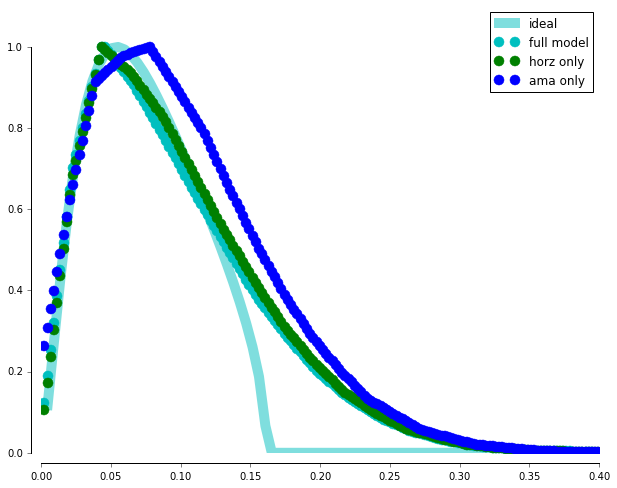

In [23]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='c', linewidth=10, alpha=0.5, label='ideal')
plt.plot(model_freqs, model_fft, 'c.', linewidth=2, markersize=20, label='full model')
plt.plot(h_freqs, h_fft, 'g.', linewidth=2, markersize=20, label='horz only')
plt.plot(a_freqs, a_fft, 'b.', linewidth=2, markersize=20, label='ama only')
plt.xlim([0,.4])
plt.legend()
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.ylim([0,1.1])

The relative error from this choice of Lagrangian multiplier is 1.31145976898e-07.


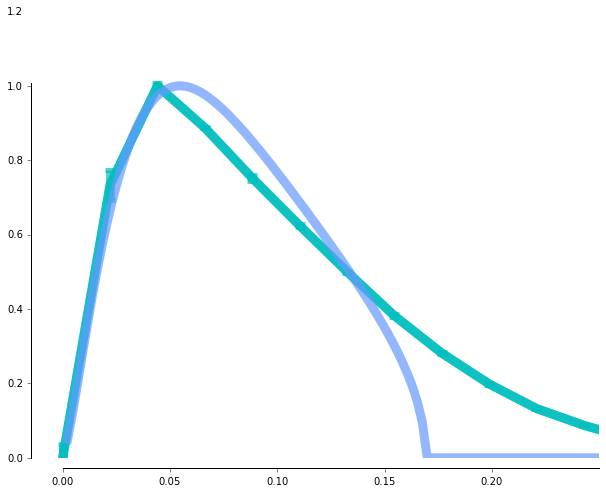

In [24]:
horz_weight, ama_weight, center_weight, surround_weight = model_popt
freq_ideal, filt_ideal, freq_expt_both, filt_expt_both, both_freqs, both_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=horz_weight, ama_weighting=ama_weight,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                                       statistics=True)

The relative error from this choice of Lagrangian multiplier is 4.07363389465e-08.


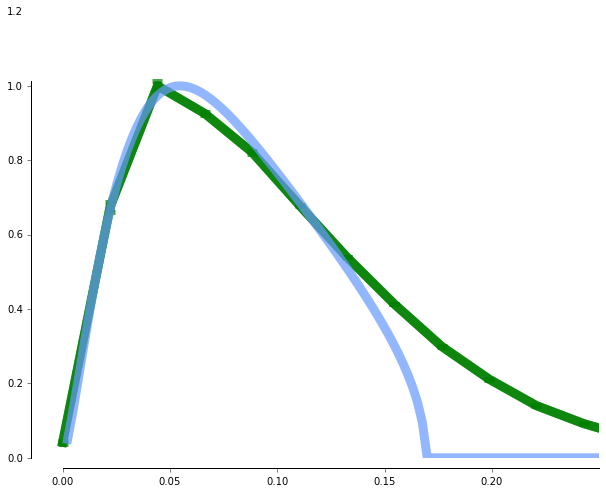

In [25]:
horz_weight = 1.0
ama_weight = 0.0
center_weight, surround_weight = h_popt
freq_ideal, filt_ideal, freq_expt_h, filt_expt_h, h_freqs, h_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=1.0, ama_weighting=0.0,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                     aggregateColor='g', statistics=True)

The relative error from this choice of Lagrangian multiplier is 1.03541516663e-07.


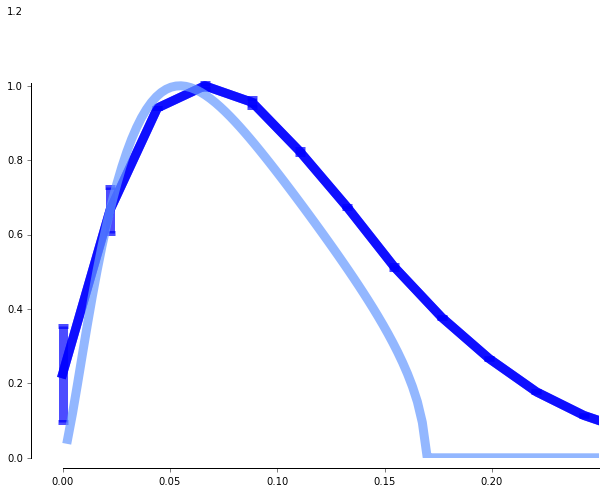

In [26]:
horz_weight = 0.0
ama_weight = 1.0
center_weight, surround_weight = a_popt
freq_ideal, filt_ideal, freq_expt_a, filt_expt_a, a_freqs, a_ffts = compare_to_experiment(originalFreqs, originalSpectra**2, 
                                                                     inputNoise=0.12, outputNoise=0.35,
                                                                     center_weighting=center_weight, surround_weighting=surround_weight,
                                                                     horz_weighting=horz_weight, ama_weighting=ama_weight,
                                                                     center_width=center_width,
                                                                     returnFlag=True, xlimit=[-0.01,0.25], 
                                                                     numPoints=10000, plotFlag='aggregate',
                                                                     aggregateColor='b', statistics=True)

In [27]:
lower_freqs = lowerer_freqs

In [28]:
np.max(lowerer_freqs)

0.39944589697064947

In [29]:
init_model_const = 0.95
init_a_const = 0.95
init_h_const = 0.95

In [30]:
model_interp = interp1d(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_model_var(model_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    model_variance = np.sum((signal_interp(lower_freqs)*model_const*model_interp(lower_freqs))**2 +
                          (input_noise * model_const * model_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - model_variance)**2

In [31]:
model_const_opt = scipy.optimize.minimize(constrain_model_var, init_model_const)
model_const = abs(model_const_opt['x'])
model_const_opt

      fun: 1.985789508251232e-13
 hess_inv: array([[ 0.01677811]])
      jac: array([ -4.42525875e-06])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 0.90319786])

In [32]:
model_variance = np.sum((more_signal_amp*model_const*model_interp(more_signal_freq))**2 +
                          (input_noise * model_const * model_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(model_variance)

1227.34527541


In [33]:
a_interp = interp1d(freq_expt_both, filt_expt_a/np.nanmax(filt_expt_a), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

def constrain_a_var(a_const):
    output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    a_variance = np.sum((more_signal_amp*a_const*a_interp(more_signal_freq))**2 +
                          (input_noise * a_const * a_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    
    return (output_variance - a_variance)**2

In [34]:
a_const_opt = scipy.optimize.minimize(constrain_a_var, init_a_const)
a_const = abs(a_const_opt['x'])
a_const_opt

      fun: 1.6284183603450292e-13
 hess_inv: array([[ 0.00565138]])
      jac: array([ -6.27997684e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 4
     njev: 10
   status: 0
  success: True
        x: array([-0.52398307])

In [35]:
a_variance = np.sum((more_signal_amp*a_const*a_interp(more_signal_freq))**2 +
                          (input_noise * a_const * a_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(a_variance)

1227.34527299


In [36]:
h_interp = interp1d(freq_expt_both, filt_expt_h/np.nanmax(filt_expt_h), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

def constrain_h_var(h_const):
    output_variance = np.sum((more_signal_amp*ideal_filter_interp(more_signal_freq))**2 +
                          (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    h_variance = np.sum((more_signal_amp*h_const*h_interp(more_signal_freq))**2 +
                          (input_noise * h_const * h_interp(more_signal_freq))**2 +
                          (output_noise)**2)
    
    return (output_variance - h_variance)**2

In [37]:
h_const_opt = scipy.optimize.minimize(constrain_h_var, init_h_const)
h_const = abs(h_const_opt['x'])
h_const_opt

      fun: 2.8034722441802727e-15
 hess_inv: array([[ 0.01475217]])
      jac: array([ -1.11562765e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([ 0.84800457])

In [38]:
h_variance = np.sum((more_signal_amp*h_const*h_interp(more_signal_freq))**2 +
                          (input_noise * h_const * h_interp(more_signal_freq))**2 +
                          (output_noise)**2)
print(h_variance)

1227.34527254


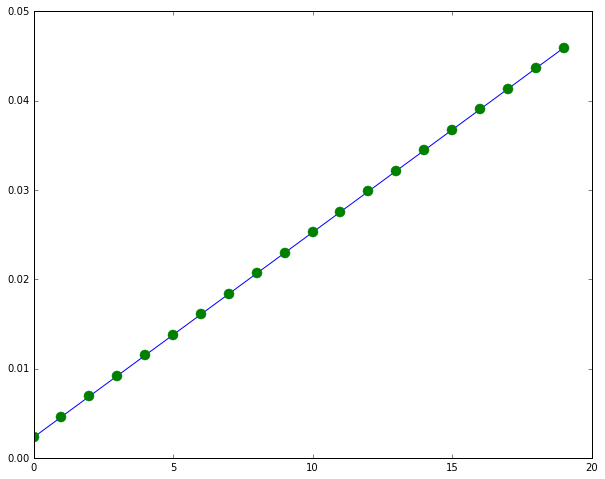

In [39]:
plt.plot(more_signal_freq[:20])
plt.plot(lower_freqs[:20], '.', markersize=20)

In [40]:
lower_amps = np.array([more_signal_amp[i] for i in range(len(more_signal_amp)) if more_signal_freq[i] <= np.max(lower_freqs)])
print(len(lower_amps))
print(len(lower_freqs))

174
174


In [41]:
cuminfo_ideal = info_at_freq(lower_freqs, lower_amps, ideal_filter_interp, output_noise=output_noise, input_noise=input_noise)
cuminfo_model = info_at_freq(lower_freqs, lower_amps, model_interp, function_const=model_const, output_noise=output_noise, input_noise=input_noise)
cuminfo_a = info_at_freq(lower_freqs, lower_amps, a_interp, function_const=a_const, output_noise=output_noise, input_noise=input_noise)
cuminfo_h = info_at_freq(lower_freqs, lower_amps, h_interp, function_const=h_const, output_noise=output_noise, input_noise=input_noise)

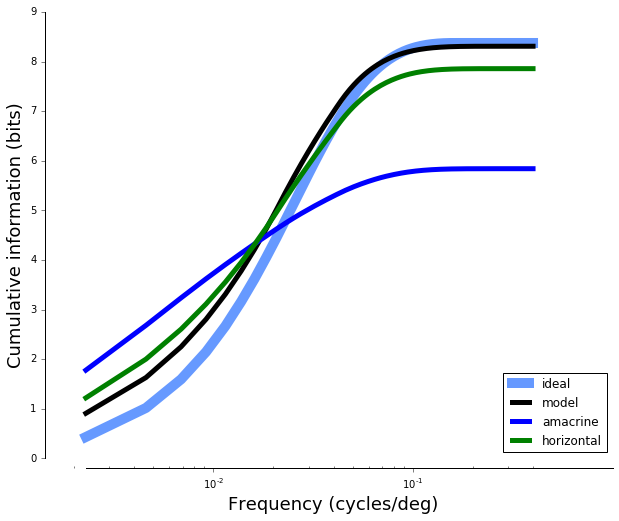

In [42]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

## How much information do ganglion cell RFs transmit?

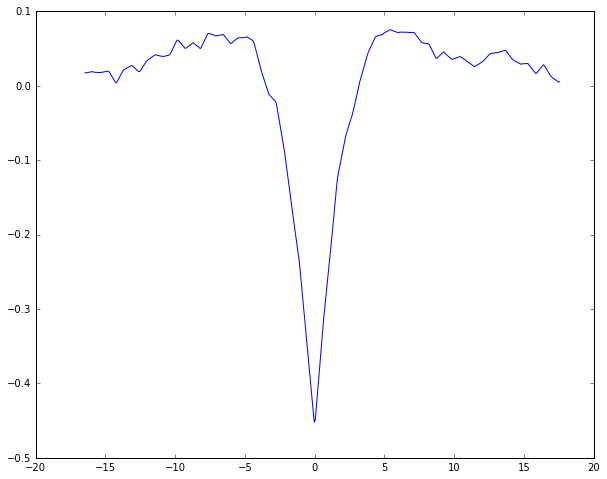

In [43]:
plt.plot(valid_space, mean_ganglion-np.mean(mean_ganglion))

In [44]:
rf_f_two_sided = abs(np.fft.fft(mean_ganglion-np.mean(mean_ganglion))) / np.prod(mean_ganglion.shape)
n = len(rf_f_two_sided)
if n % 2 == 0:
    rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
else:
    rf_f_one_sided = rf_f_two_sided[:(n-1)/2 + 1]
spacing = valid_space[-1] - valid_space[-2]
rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

ganglion_freqs = rf_freqs_one_sided
ganglion_amps = rf_f_one_sided

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 4)

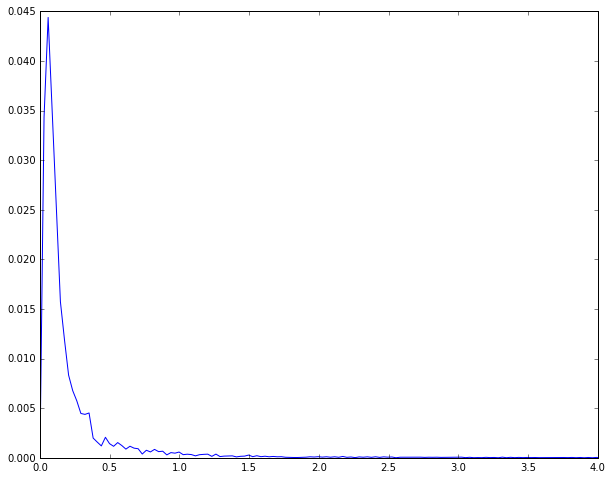

In [45]:
plt.plot(ganglion_freqs, ganglion_amps)
plt.xlim([0,4])

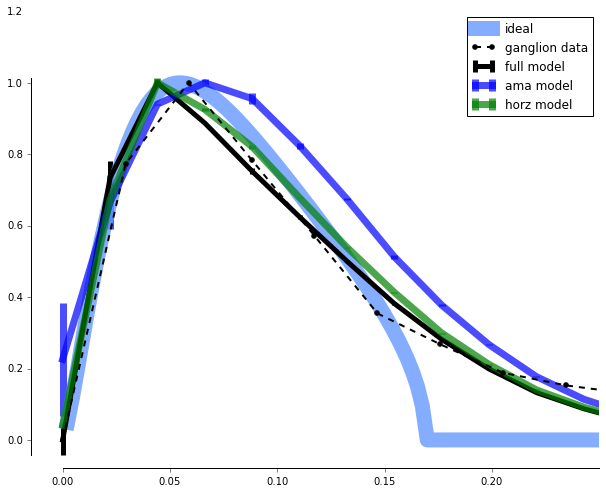

In [46]:
plt.plot(freq_ideal, filt_ideal/np.nanmax(filt_ideal), color='#6699ff', linewidth=15, alpha=0.8, label='ideal')
plt.errorbar(freq_expt_both, filt_expt_both/np.nanmax(filt_expt_both), yerr=sem(both_ffts/np.nanmax(filt_expt_both)), 
             color='k', linewidth=5, alpha=1.0, capthick=5, capsize=0, label='full model')
plt.errorbar(freq_expt_a, filt_expt_a/np.nanmax(filt_expt_a), yerr=sem(a_ffts/np.nanmax(filt_expt_a)),
            color='b', alpha=0.7, linewidth=7, capthick=5, capsize=0, label='ama model')
plt.errorbar(freq_expt_h, filt_expt_h/np.nanmax(filt_expt_h), yerr=sem(h_ffts/np.nanmax(filt_expt_h)),
            color='g', alpha=0.7, linewidth=7, capthick=5, capsize=0, label='horz model')
plt.plot(ganglion_freqs, ganglion_amps/np.nanmax(ganglion_amps), 'k.--', markersize=10, linewidth=2, label='ganglion data')
# plt.plot(a_freqs, a_fft, 'b.', linewidth=2, markersize=20, label='ama only', alpha=0.5)
plt.xlim([-0.01,0.25])
plt.ylim([-0.05, 1.2])
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.legend()
# plt.savefig('Fig4B-C_one_plot.pdf', fonttype=42)

In [47]:
ganglion_interp = interp1d(ganglion_freqs, ganglion_amps/np.nanmax(ganglion_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_ganglion_var(ganglion_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    ganglion_variance = np.sum((signal_interp(lower_freqs)*ganglion_const*ganglion_interp(lower_freqs))**2 +
                          (input_noise * ganglion_const * ganglion_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - ganglion_variance)**2

In [48]:
init_ganglion_const = 1.02

In [49]:
ganglion_const_opt = scipy.optimize.minimize(constrain_ganglion_var, init_ganglion_const)
ganglion_const = ganglion_const_opt['x']
ganglion_const_opt

      fun: 1.2692861679397837e-15
 hess_inv: array([[ 0.02226495]])
      jac: array([ -3.05478896e-09])
  message: 'Optimization terminated successfully.'
     nfev: 18
      nit: 4
     njev: 6
   status: 0
  success: True
        x: array([ 1.04157998])

In [50]:
cuminfo_ganglion = info_at_freq(lower_freqs, lower_amps, ganglion_interp, function_const=ganglion_const, output_noise=output_noise, input_noise=input_noise)

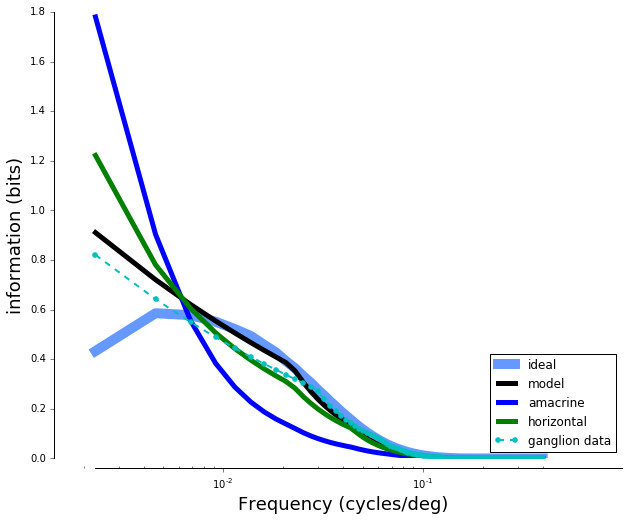

In [51]:
plt.plot(lower_freqs, cuminfo_ideal, color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, cuminfo_model, color='k', linewidth=5, label='model')
plt.plot(lower_freqs, cuminfo_a, color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, cuminfo_h, color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, cuminfo_ganglion, 'c.--', linewidth=2, markersize=10, label='ganglion data')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

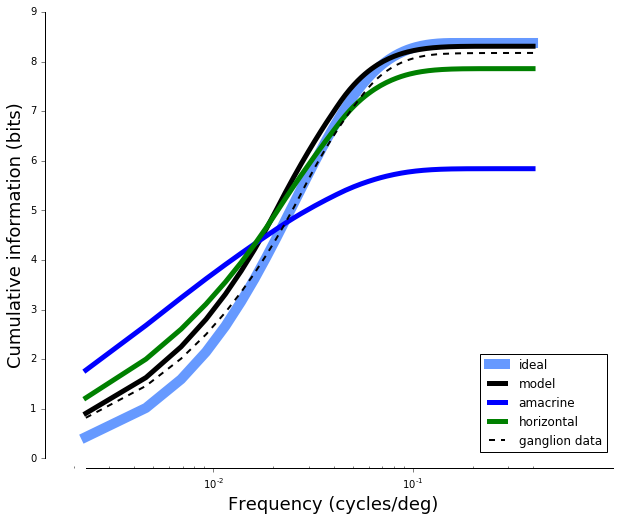

In [52]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, np.cumsum(cuminfo_ganglion), 'k--', linewidth=2, markersize=10, label='ganglion data')
plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])

In [53]:
np.sum(cuminfo_ganglion)

8.1759189869353985

In [54]:
np.sum(cuminfo_ideal)

8.3767518307674571

In [55]:
np.sum(cuminfo_ganglion)/np.sum(cuminfo_ideal)

0.97602497389329268

In [56]:
np.sum(cuminfo_model)/np.sum(cuminfo_ideal)

0.99217620826188946

In [57]:
np.sum(cuminfo_h)/np.sum(cuminfo_ideal)

0.93824227316811903

In [58]:
np.sum(cuminfo_a)/np.sum(cuminfo_ideal)

0.69745316173564786

## Plot cumulative information including center

In [59]:
center = gaussian(x=valid_space, sigma=center_width, mu=0)
rf_f_two_sided = abs(np.fft.fft(center)) / np.prod(center.shape)
n = len(rf_f_two_sided)
if n % 2 == 0:
    rf_f_one_sided = rf_f_two_sided[:n/2 + 1]
else:
    rf_f_one_sided = rf_f_two_sided[:(n-1)/2 + 1]
spacing = valid_space[-1] - valid_space[-2]
rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

center_freqs = rf_freqs_one_sided
center_amps = rf_f_one_sided

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(0, 1)

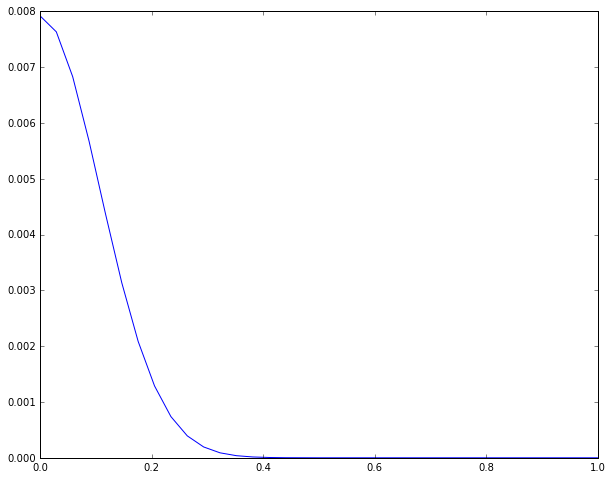

In [60]:
plt.plot(center_freqs, center_amps)
plt.xlim([0,1])

In [61]:
center_interp = interp1d(center_freqs, center_amps/np.nanmax(center_amps), kind='slinear', 
                        fill_value=[0.0], bounds_error=False)

signal_interp = interp1d(more_signal_freq, more_signal_amp, kind='slinear')

def constrain_center_var(center_const):
    output_variance = np.sum((signal_interp(lower_freqs)*ideal_filter_interp(lower_freqs))**2 +
                          (input_noise * ideal_filter_interp(lower_freqs))**2 +
                          (output_noise)**2)
    center_variance = np.sum((signal_interp(lower_freqs)*center_const*center_interp(lower_freqs))**2 +
                          (input_noise * center_const * center_interp(lower_freqs))**2 +
                          (output_noise)**2)
    
    return (output_variance - center_variance)**2


In [62]:
init_center_const = 0.7
center_const_opt = scipy.optimize.minimize(constrain_center_var, init_center_const)
center_const = abs(center_const_opt['x'])
center_const_opt

      fun: 4.721804177051414e-14
 hess_inv: array([[ 0.00058901]])
      jac: array([ -1.36777688e-08])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 9
     njev: 10
   status: 0
  success: True
        x: array([-0.16941065])

In [63]:
cuminfo_center = info_at_freq(lower_freqs, lower_amps, center_interp, function_const=center_const, output_noise=output_noise, input_noise=input_noise)

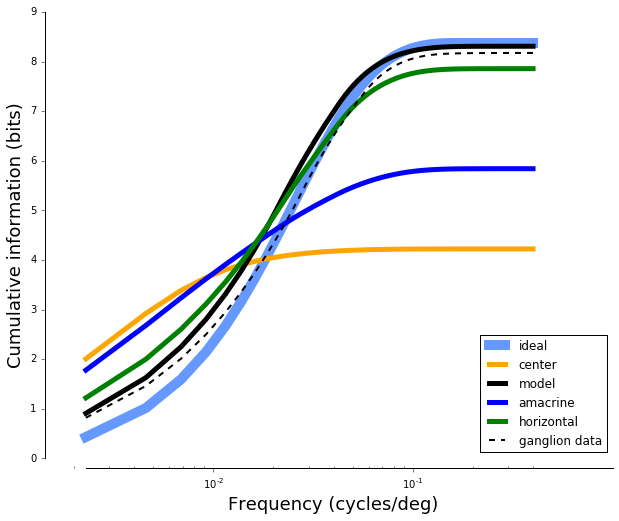

In [64]:
plt.plot(lower_freqs, np.cumsum(cuminfo_ideal), color='#6699ff', linewidth=10, label='ideal')
plt.plot(lower_freqs, np.cumsum(cuminfo_center), 'orange', linewidth=5, label='center')
plt.plot(lower_freqs, np.cumsum(cuminfo_model), color='k', linewidth=5, label='model')
plt.plot(lower_freqs, np.cumsum(cuminfo_a), color='b', linewidth=5, label='amacrine')
plt.plot(lower_freqs, np.cumsum(cuminfo_h), color='g', linewidth=5, label='horizontal')
plt.plot(lower_freqs, np.cumsum(cuminfo_ganglion), 'k--', linewidth=2, markersize=10, label='ganglion data')

plt.xlabel('Frequency (cycles/deg)', fontsize=18)
plt.ylabel('Cumulative information (bits)', fontsize=18)
plt.legend(loc='lower right')
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
plt.xscale('log')
plt.xlim([1.6*10e-4, 10e-1])
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.savefig('Cumulative_info_plot.pdf', fonttype=42)

# Generate colormaps of information as fn of model params

In [238]:
import traceback
import warnings
import sys

def warn_with_traceback(message, category, filename, lineno, file=None, line=None):
    traceback.print_stack()
    log = file if hasattr(file,'write') else sys.stderr
    log.write(warnings.formatwarning(message, category, filename, lineno, line))

warnings.showwarning = warn_with_traceback

## Modify filter_model to accept normalized parameters

In [87]:
def filter_express(horz_weight, center_weight, center_width=center_width):
    horz_weight = np.min([1.0, abs(horz_weight)])
    ama_weight = 1.0 - horz_weight
    center_weight = np.min([1.0, abs(center_weight)])
    surround_weight = 1.0 - center_weight
    
    # Get original data
    horz_pfs = get_horizontal_projective_field()
    ama_pfs  = get_amacrine_projective_field()

    # get means of the projective fields
    space_h, horz_pf, horz_sem = get_mean(horz_pfs)
    space_a, ama_pf, ama_sem   = get_mean(ama_pfs)

    # interpolate horz and ama to get a unified space; mode='valid'
    horz_interp = interp1d(space_h, horz_pf, kind='slinear')
    ama_interp  = interp1d(space_a, ama_pf, kind='slinear')
    space       = np.linspace(np.max([np.min(space_h), np.min(space_a)]), np.min([np.max(space_h), np.max(space_a)]), 100)

    # project interpolations on unified space
    horz_pf     = horz_interp(space)
    ama_pf      = ama_interp(space)

    # set sampling rate
    spacing = space[-1] - space[-2]

    # make surround
    surround = horz_weight * horz_pf + ama_weight * ama_pf

    # make center
    center = gaussian(x=space, sigma=center_width, mu=space[abs(surround)==np.max(abs(surround))]) # gaussian

    # put them together
    if len(center.shape) > 1:
        center = center.squeeze()
    rf = center_weight * center + surround_weight * surround

    # Amplitude Spectrum of RF
    rf_f_two_sided = abs(np.fft.fft(rf)) / np.prod(rf.shape)
    n = len(rf_f_two_sided)
    if n % 2 == 0:
        rf_f_one_sided = rf_f_two_sided[:int((n/2) + 1)]
    else:
        rf_f_one_sided = rf_f_two_sided[:int(((n-1)/2) + 1)]
    rf_freqs_one_sided = np.linspace(0, 1./(2*spacing), len(rf_f_one_sided))

    rf_interp = interp1d(rf_freqs_one_sided, rf_f_one_sided, kind='slinear', fill_value=[0.0], bounds_error=False)
    
    return rf_interp

In [88]:
def info_fun(weights, center_width=center_width, init_filt_const=0.8):
    horz_weight, center_weight = weights
    
    # get model
    filt_interp = filter_express(horz_weight, center_weight, center_width=center_width)
    
    # constrain variance
    def constrain_filt_var(filt_const):
        output_variance = np.sum((signal_interp(more_signal_freq)*ideal_filter_interp(more_signal_freq))**2 +
                              (input_noise * ideal_filter_interp(more_signal_freq))**2 +
                              (output_noise)**2)
        filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                              (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                              (output_noise)**2)

        return (output_variance - filt_variance)**2
    filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])
    
    # get info
    infos = info_at_freq(more_signal_freq, more_signal_amp, filt_interp, function_const=filt_const, input_noise=0.12, output_noise=0.35)
    return -np.sum(infos)

## Scipy.optimize.minimize takes too long... let's use descent

In [373]:
import traceback
import warnings
import sys
warnings.showwarning = None

# Colormaps as fun of input noise

In [66]:
input_noises = [0.01, 0.4]
info_colormaps_vs_noise = {}
mse_colormaps_vs_noise = {}

resolution = 150
target_variance = 1000
horz_weights = np.linspace(0.,1.,resolution)
center_weights = np.linspace(0.,1.,resolution)
init_filt_const = 0.8

for input_noise in input_noises:
    info_color_map = np.zeros((resolution, resolution))
    mse_color_map = np.zeros((resolution, resolution))

    for idh,hw in enumerate(horz_weights):
        for idc,cw in enumerate(center_weights):
            aw = 1.0 - hw
            sw = 1.0 - cw
            filt_interp = filter_model(hw, aw, cw, sw, center_width=center_width)

            def constrain_filt_var(filt_const):
                filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                                      (input_noise * filt_const * filt_interp(more_signal_freq))**2 +
                                      (output_noise)**2)

                return (target_variance - filt_variance)**2


            filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
            filt_const = abs(filt_const_opt['x'])

            # compute total information for this particular model
            info_color_map[idh,idc] = np.sum(info_at_freq(more_signal_freq, more_signal_amp, 
                                                                  filt_interp, function_const=filt_const, input_noise=input_noise, output_noise=output_noise))

            # compute the MSE difference between this model filter and the ideal filter
            mse_color_map[idh,idc] = np.mean((ideal_filter_interp(more_signal_freq) - filt_const*filt_interp(more_signal_freq))**2)

        if idh % 10 == 0:
            print('On iteration %d/%d' %(idh*resolution, resolution*resolution))
            
    info_colormaps_vs_noise[input_noise] = info_color_map
    mse_colormaps_vs_noise[input_noise] = mse_color_map


On iteration 0/22500
On iteration 1500/22500
On iteration 3000/22500
On iteration 4500/22500
On iteration 6000/22500
On iteration 7500/22500
On iteration 9000/22500
On iteration 10500/22500
On iteration 12000/22500
On iteration 13500/22500
On iteration 15000/22500
On iteration 16500/22500
On iteration 18000/22500
On iteration 19500/22500
On iteration 21000/22500
On iteration 0/22500
On iteration 1500/22500
On iteration 3000/22500
On iteration 4500/22500
On iteration 6000/22500
On iteration 7500/22500
On iteration 9000/22500
On iteration 10500/22500
On iteration 12000/22500
On iteration 13500/22500
On iteration 15000/22500
On iteration 16500/22500
On iteration 18000/22500
On iteration 19500/22500
On iteration 21000/22500


In [182]:
# import h5py

In [184]:
# with h5py.File('info_grid_search.h5', 'w') as f:
#     dset = f.create_dataset('info_colormap', data=info_color_map)
#     dset2 = f.create_dataset('mse_colormap', data=mse_color_map)
#     dset3 = f.create_dataset('horz_weight_yaxis', data=horz_weights)
#     dset4 = f.create_dataset('center_weight_xaxis', data=center_weights)

In [71]:
center_weights[0]

0.0

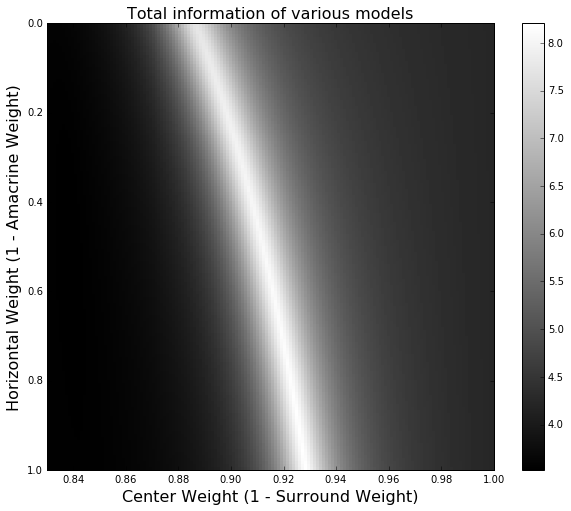

In [185]:
plt.imshow(info_colormaps_vs_noise[input_noises[0]], cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of models with input noise %0.3f' %input_noises[0], fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

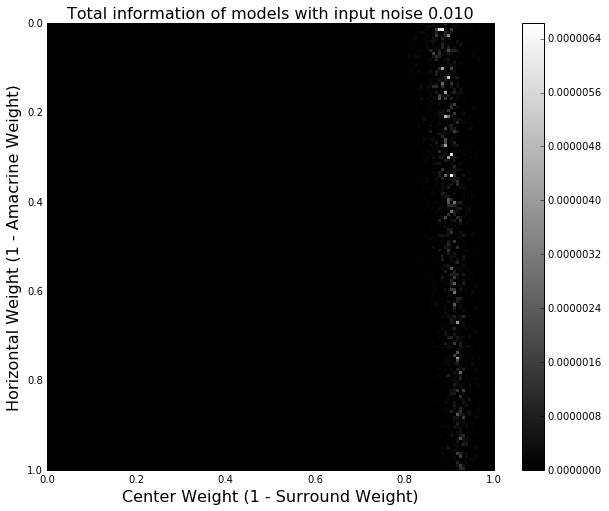

In [72]:
plt.imshow(info_colormaps_vs_noise[input_noises[0]], cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of models with input noise %0.3f' %input_noises[0], fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

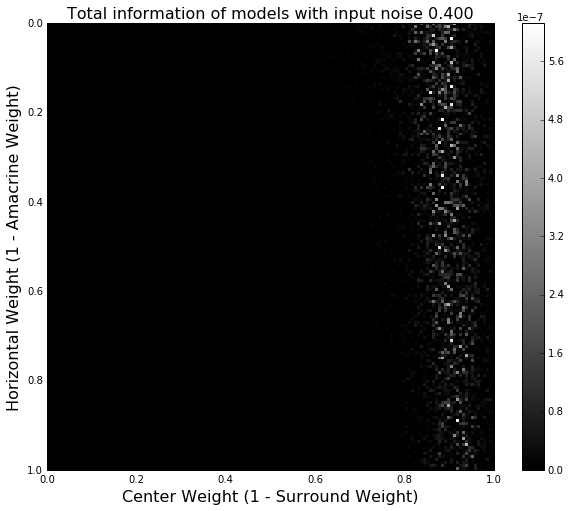

In [67]:
plt.imshow(info_colormaps_vs_noise[input_noises[1]], cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.colorbar()
plt.title('Total information of models with input noise %0.3f' %input_noises[1], fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

In [ ]:
with h5py.File('info_grid_search_1e-2.h5', 'w') as f:
    dset = f.create_dataset('info_colormap', data=info_colormaps_vs_noise[input_noises[0]])
    dset2 = f.create_dataset('mse_colormap', data=mse_colormaps_vs_noise[input_noises[0]])
    dset3 = f.create_dataset('horz_weight_yaxis', data=horz_weights)
    dset4 = f.create_dataset('center_weight_xaxis', data=center_weights)

In [68]:
input_noises[0]

0.01

In [70]:
1e-2

0.01

## investigate opposite extremes of horz weight at low noise

In [133]:
opposite_filters = []
hws = [horz_weights[1], horz_weights[-2]]
cws = []
target_variance = 10000
init_filt_const = 9.9

for hw in hws:
    aw = 1.0 - hw
    cw = center_weights[np.argmax(info_colormaps_vs_noise[input_noises[0]][np.argmin(abs(hw - horz_weights))])]
    sw = 1.0 - cw
    cws.append(cw)
    print('Horz weight %f, center weight %f, info %f' %(hw, cw, np.max(info_colormaps_vs_noise[input_noises[0]][np.argmin(abs(hw - horz_weights))])))

    filt_interp = filter_model(hw, aw, cw, sw, center_width=center_width)

    def constrain_filt_var(filt_const):
        filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                              (input_noises[0] * filt_const * filt_interp(more_signal_freq))**2 +
                              (output_noise)**2)

        return (target_variance - filt_variance)**2


    filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])
    
    opposite_filters.append(filt_const * filt_interp(more_signal_freq))

Horz weight 0.006711, center weight 0.852349, info 0.000000
Horz weight 0.993289, center weight 0.926174, info 0.000001


In [134]:
filt_const_opt

      fun: 2.544486191369931e-14
 hess_inv: array([[ 560.68009056]])
      jac: array([  4.83260082e-07])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 2
     njev: 15
   status: 0
  success: True
        x: array([ 12356.86743972])

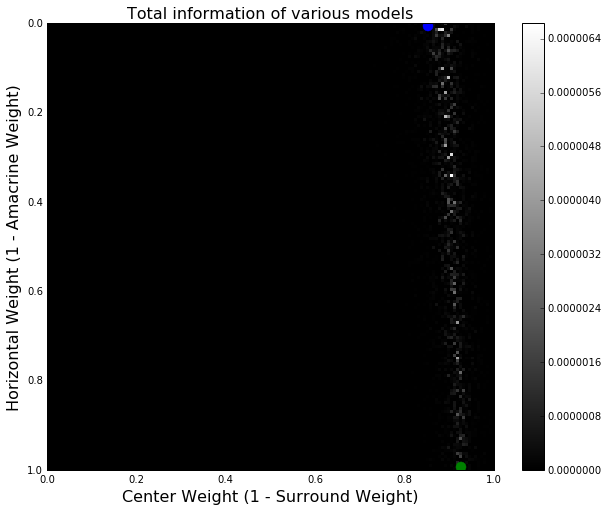

In [123]:
plt.imshow(info_colormaps_vs_noise[input_noises[0]], cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.plot(cws[0], hws[0], 'b.', markersize=20)
plt.plot(cws[1], hws[1], 'g.', markersize=20)
# plt.xlim([0.83,1])
plt.colorbar()
plt.title('Total information of various models', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

In [124]:
cws[0]

0.8523489932885906

In [125]:
hws[0]

0.0067114093959731542

(0, 1)

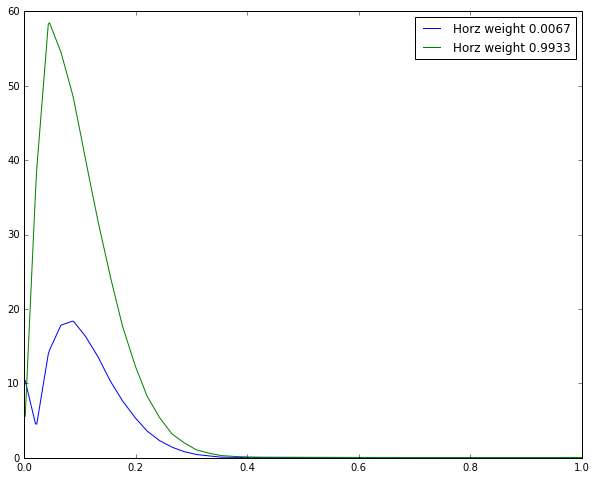

In [126]:
plt.plot(more_signal_freq, opposite_filters[0], 'b', label='Horz weight %0.4f' %hws[0])
plt.plot(more_signal_freq, opposite_filters[1], 'g', label='Horz weight %0.4f' %hws[1])
plt.legend()
plt.xlim([0,1])

How do these two filters have the same variance?

In [127]:
np.sum((signal_interp(more_signal_freq)*opposite_filters[0])**2 +
                              (input_noises[0] * opposite_filters[0])**2 +
                              (output_noise)**2)

9999.9999999788652

In [128]:
np.sum((signal_interp(more_signal_freq)*opposite_filters[1])**2 +
                              (input_noises[0] * opposite_filters[1])**2 +
                              (output_noise)**2)

10000.000000159514

## Look at opposite filters at high noise

In [135]:
opposite_filters_high_noise = []
hws = [horz_weights[1], horz_weights[-2]]
cws_high_noise = []
target_variance = 10000
init_filt_const = 9.9

for hw in hws:
    aw = 1.0 - hw
    cw = center_weights[np.argmax(info_colormaps_vs_noise[input_noises[1]][np.argmin(abs(hw - horz_weights))])]
    sw = 1.0 - cw
    cws_high_noise.append(cw)
    print('Horz weight %f, center weight %f, info %f' %(hw, cw, np.max(info_colormaps_vs_noise[input_noises[1]][np.argmin(abs(hw - horz_weights))])))

    filt_interp = filter_model(hw, aw, cw, sw, center_width=center_width)

    def constrain_filt_var(filt_const):
        filt_variance = np.sum((signal_interp(more_signal_freq)*filt_const*filt_interp(more_signal_freq))**2 +
                              (input_noises[1] * filt_const * filt_interp(more_signal_freq))**2 +
                              (output_noise)**2)

        return (target_variance - filt_variance)**2


    filt_const_opt = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
    filt_const = abs(filt_const_opt['x'])
    
    opposite_filters_high_noise.append(filt_const * filt_interp(more_signal_freq))

Horz weight 0.006711, center weight 0.899329, info 0.000000
Horz weight 0.993289, center weight 0.939597, info 0.000000


In [130]:
filt_const_opt

      fun: 6.537080531971102e-16
 hess_inv: array([[ 0.04245137]])
      jac: array([  6.24233998e-12])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 3
     njev: 14
   status: 0
  success: True
        x: array([ 5113.91366474])

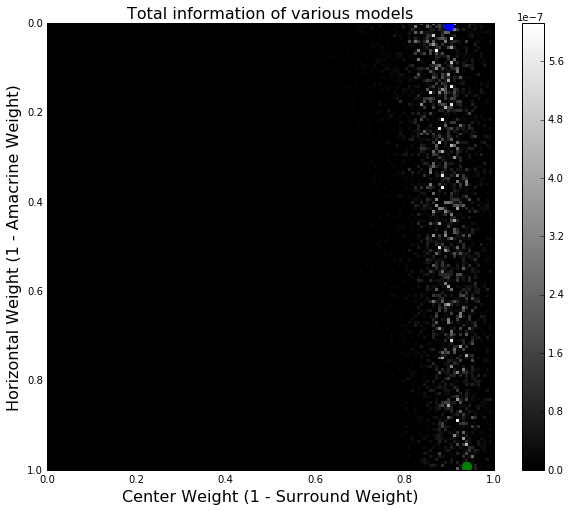

In [136]:
plt.imshow(info_colormaps_vs_noise[input_noises[1]], cmap='gray', extent=(center_weights[0], center_weights[-1], horz_weights[-1], horz_weights[0]),
          aspect='auto')
plt.plot(cws_high_noise[0], hws[0], 'b.', markersize=20)
plt.plot(cws_high_noise[1], hws[1], 'g.', markersize=20)
# plt.xlim([0.83,1])
plt.colorbar()
plt.title('Total information of various models', fontsize=16)
plt.xlabel('Center Weight (1 - Surround Weight)', fontsize=16)
plt.ylabel('Horizontal Weight (1 - Amacrine Weight)', fontsize=16)

(0, 0.6)

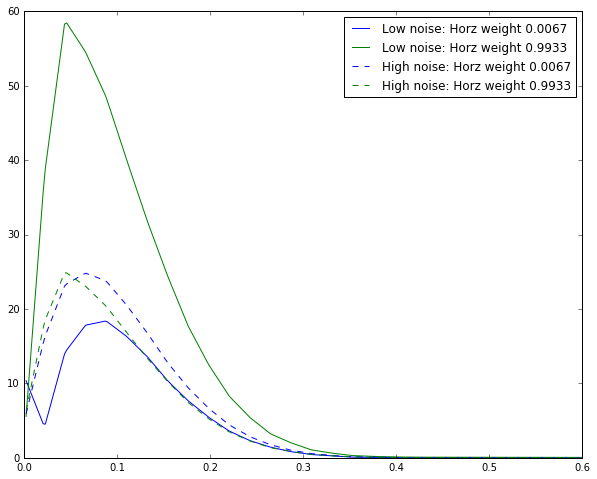

In [140]:
plt.plot(more_signal_freq, opposite_filters[0], 'b', label='Low noise: Horz weight %0.4f' %hws[0])
plt.plot(more_signal_freq, opposite_filters[1], 'g', label='Low noise: Horz weight %0.4f' %hws[1])
plt.plot(more_signal_freq, opposite_filters_high_noise[0], 'b--', label='High noise: Horz weight %0.4f' %hws[0])
plt.plot(more_signal_freq, opposite_filters_high_noise[1], 'g--', label='High noise: Horz weight %0.4f' %hws[1])
plt.legend()
plt.xlim([0,0.6])

In [141]:
target_variance

10000

In [233]:
filt_ideal_low_noise = unique_soln(more_signal_amp**2, input_noises[0], output_noise)
filt_ideal_high_noise = unique_soln(more_signal_amp**2, input_noises[1], output_noise)

# constrain variance of these ideal filters
def constrain_filt_var(filt_const):
    filt_variance = np.sum((more_signal_amp * filt_const * filt_ideal_low_noise)**2 +
                          (input_noises[0] * filt_const * filt_ideal_low_noise)**2 +
                          (output_noise)**2)
    return (target_variance - filt_variance)**2

filt_const_opt_low_noise = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
filt_const_low_noise = abs(filt_const_opt_low_noise['x'])
filt_ideal_low_noise *= filt_const_low_noise

# constrain variance of these ideal filters
def constrain_filt_var(filt_const):
    filt_variance = np.sum((more_signal_amp * filt_const * filt_ideal_high_noise)**2 +
                          (input_noises[1] * filt_const * filt_ideal_high_noise)**2 +
                          (output_noise)**2)
    return (target_variance - filt_variance)**2

filt_const_opt_high_noise = scipy.optimize.minimize(constrain_filt_var, init_filt_const)
filt_const_high_noise = abs(filt_const_opt_high_noise['x'])
filt_ideal_high_noise *= filt_const_high_noise

The relative error from this choice of Lagrangian multiplier is 7.45687712704e-07.
The relative error from this choice of Lagrangian multiplier is 2.58280020708e-08.


In [234]:
filt_const_opt_low_noise

      fun: 8.816215638292772e-11
 hess_inv: array([[  3.14823975e-07]])
      jac: array([ -2.29235098e-09])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([ 13.92618648])

In [235]:
filt_const_opt_high_noise

      fun: 1.1017815805651289e-10
 hess_inv: array([[  2.51915401e-07]])
      jac: array([  2.56264143e-09])
  message: 'Optimization terminated successfully.'
     nfev: 27
      nit: 8
     njev: 9
   status: 0
  success: True
        x: array([ 12.45734598])

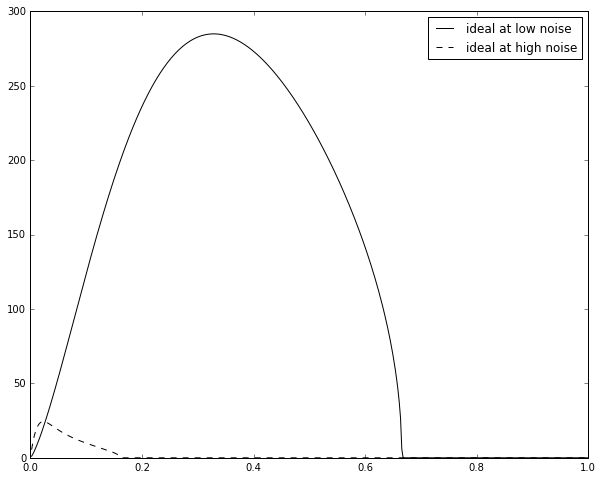

In [236]:
plt.plot(more_signal_freq, filt_ideal_low_noise, 'k', label='ideal at low noise')
plt.plot(more_signal_freq, filt_ideal_high_noise, 'k--', label='ideal at high noise')
plt.xlim([0,1])
plt.legend()

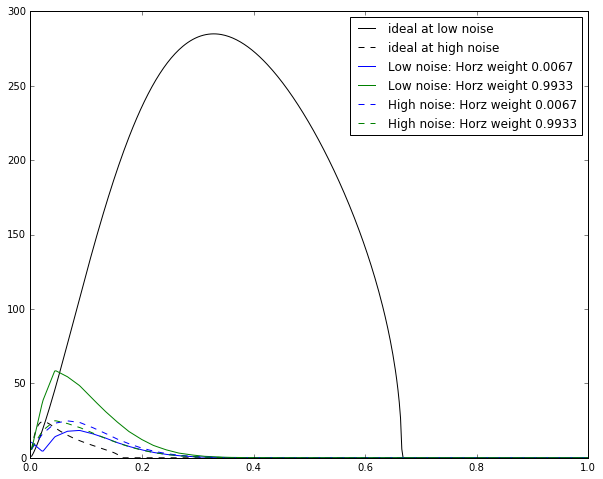

In [237]:
plt.plot(more_signal_freq, filt_ideal_low_noise, 'k', label='ideal at low noise')
plt.plot(more_signal_freq, filt_ideal_high_noise, 'k--', label='ideal at high noise')
plt.plot(more_signal_freq, opposite_filters[0], 'b', label='Low noise: Horz weight %0.4f' %hws[0])
plt.plot(more_signal_freq, opposite_filters[1], 'g', label='Low noise: Horz weight %0.4f' %hws[1])
plt.plot(more_signal_freq, opposite_filters_high_noise[0], 'b--', label='High noise: Horz weight %0.4f' %hws[0])
plt.plot(more_signal_freq, opposite_filters_high_noise[1], 'g--', label='High noise: Horz weight %0.4f' %hws[1])
plt.xlim([0,1])
plt.legend()

I just don't believe that all these filters have the same output variance...

In [238]:
np.sum((signal_interp(more_signal_freq)*opposite_filters[0])**2 +
                              (input_noises[0] * opposite_filters[0])**2 +
                              (output_noise)**2)

9999.999999977832

In [239]:
np.sum((signal_interp(more_signal_freq)*opposite_filters[1])**2 +
                              (input_noises[0] * opposite_filters[1])**2 +
                              (output_noise)**2)

10000.000000159514

In [240]:
np.sum((signal_interp(more_signal_freq)*opposite_filters_high_noise[0])**2 +
                              (input_noises[1] * opposite_filters_high_noise[0])**2 +
                              (output_noise)**2)

9999.9999999812644

In [241]:
np.sum((signal_interp(more_signal_freq)*opposite_filters_high_noise[1])**2 +
                              (input_noises[1] * opposite_filters_high_noise[1])**2 +
                              (output_noise)**2)

9999.9999999744323

In [242]:
np.sum((signal_interp(more_signal_freq)*filt_ideal_low_noise)**2 +
                              (input_noises[0] * filt_ideal_low_noise)**2 +
                              (output_noise)**2)

9999.9999906105295

In [243]:
np.sum((signal_interp(more_signal_freq)*filt_ideal_high_noise)**2 +
                              (input_noises[1] * filt_ideal_high_noise)**2 +
                              (output_noise)**2)

9999.9999895034216

In [270]:
def signal_var(signal, filt, freq=None, mode='array'):
    if mode is 'array':
        return (signal*filt)**2
    elif mode is 'interpolate':
        return (signal(freq)*filt(freq))**2
    
def noise_var(input_noise, output_noise, filt, freq=None, mode='array'):
    if mode is 'array':
        return (input_noise*filt)**2 + output_noise**2
    elif mode is 'interpolate':
        return (input_noise*filt(freq))**2 + output_noise**2
    
def mutual_info(signal, input_noise, output_noise, filt, mode='sum'):
    s = signal_var(signal, filt)
    n = noise_var(input_noise, output_noise, filt)
    
    if mode is 'sum':
        return np.sum(0.5*np.log2(1. + s/n))
    else:
        return 0.5*np.log2(1. + s/n)

Get information of these filters

In [271]:
mutual_info(more_signal_amp, input_noises[0], output_noise, opposite_filters[0])

153.87351094313746

In [272]:
mutual_info(more_signal_amp, input_noises[0], output_noise, opposite_filters[1])

233.58099410793886

In [273]:
mutual_info(more_signal_amp, input_noises[1], output_noise, opposite_filters_high_noise[0])

21.190201147118401

In [274]:
mutual_info(more_signal_amp, input_noises[1], output_noise, opposite_filters_high_noise[1])

21.193766324616764

In [275]:
mutual_info(more_signal_amp, input_noises[0], output_noise, filt_ideal_low_noise)

367.21238799083619

In [276]:
mutual_info(more_signal_amp, input_noises[1], output_noise, filt_ideal_high_noise)

21.056109267577092

In [277]:
np.sum(signal_var(more_signal_amp, opposite_filters[0])) + np.sum(noise_var(input_noises[0], output_noise, opposite_filters[0]))

9999.999999977832

In [278]:
np.sum(signal_var(more_signal_amp, filt_ideal_low_noise)) + np.sum(noise_var(input_noises[0], output_noise, filt_ideal_low_noise))

9999.9999906105313

### It should not be possible to have a filter with same output variance but higher information than the ideal filter!

Summing after finding info at each frequency

In [279]:
np.sum(0.5*np.log2(1+signal_var(more_signal_amp, filt_ideal_low_noise)/noise_var(input_noises[0], output_noise, filt_ideal_low_noise)))

367.21238799083619

In [280]:
np.sum(0.5*np.log2(1+signal_var(more_signal_amp, opposite_filters[0])/noise_var(input_noises[0], output_noise, opposite_filters[0])))

153.87351094313746

Summing signal variance and summing noise variance before dividing

In [255]:
0.5*np.log2(1+np.sum(signal_var(more_signal_amp, filt_ideal_low_noise))/np.sum(noise_var(input_noises[0], output_noise, filt_ideal_low_noise)))

0.99711831928944938

In [256]:
0.5*np.log2(1+np.sum(signal_var(more_signal_amp, opposite_filters[0]))/np.sum(noise_var(input_noises[0], output_noise, opposite_filters[0])))

1.5137600612120481

Summing signal/noise variance before taking log

In [257]:
0.5*np.log2(1+np.sum(signal_var(more_signal_amp, filt_ideal_low_noise)/noise_var(input_noises[0], output_noise, filt_ideal_low_noise)))

6.7488519143429517

In [258]:
0.5*np.log2(1+np.sum(signal_var(more_signal_amp, opposite_filters[0])/noise_var(input_noises[0], output_noise, opposite_filters[0])))

8.0048660547367927

What do plots of these look like?

(0, 1)

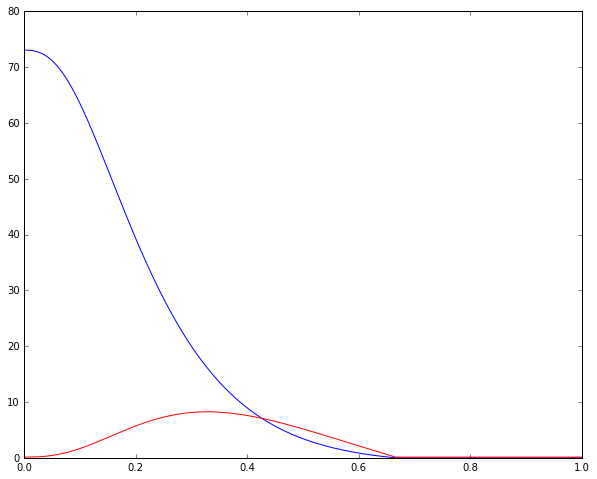

In [261]:
plt.plot(more_signal_freq, signal_var(more_signal_amp, filt_ideal_low_noise), 'b')
plt.plot(more_signal_freq, noise_var(input_noises[0], output_noise, filt_ideal_low_noise), 'r')
plt.xlim([0,1])

Think about the effect of adding more high frequency channels that are just noise. If you take log of sum(signal_var)/sum(noise_var), the denominator will get larger and you will decrease the amount of information. However, this doesn't make sense, because you can always just ignore those noise channels and just extract information from the same channels as before you added the high frequency channels.  

On the other hand, taking sum of log 1+ (signal_var/noise_var) over each frequency will result in your information being constant even as you add additional noise variance in new channels.

In [262]:
? info_at_freq

In [263]:
filt_interp_blah = interp1d(more_signal_freq, filt_ideal_low_noise)
blah = info_at_freq(more_signal_freq, more_signal_amp, filt_interp_blah, input_noise=input_noises[0], output_noise=output_noise)

In [265]:
np.sum(blah)

367.21238799083619

(0, 1)

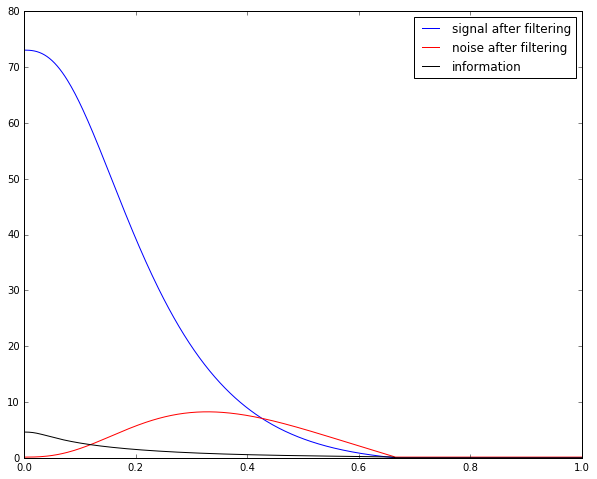

In [269]:
plt.plot(more_signal_freq, signal_var(more_signal_amp, filt_ideal_low_noise), 'b', label='signal after filtering')
plt.plot(more_signal_freq, noise_var(input_noises[0], output_noise, filt_ideal_low_noise), 'r', label='noise after filtering')
plt.plot(more_signal_freq, blah, 'k', label='information')
plt.legend()
plt.xlim([0,1])